# Radon Signs Detection - Multiple Approaches Comparison
This notebook explores multiple blob detection approaches to identify radon signs in images, analyzing:
- Number of detections per image
- Dimensions of each detected object
- Positions (x, y coordinates) of each object

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage.io import imread
from skimage import exposure, filters
from skimage.feature import canny
from skimage.measure import label, regionprops
from skimage.transform import hough_circle, hough_circle_peaks
import cv2
import glob
import pandas as pd
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

## Load Sample Images

Found 13 images
Images:
  - 1.bmp
  - 10.bmp
  - 11.bmp
  - 12.bmp
  - 13.bmp
  ... and 8 more

Sample Image: 1.bmp
Shape: (960, 1280), Min: 3.00, Max: 255.00


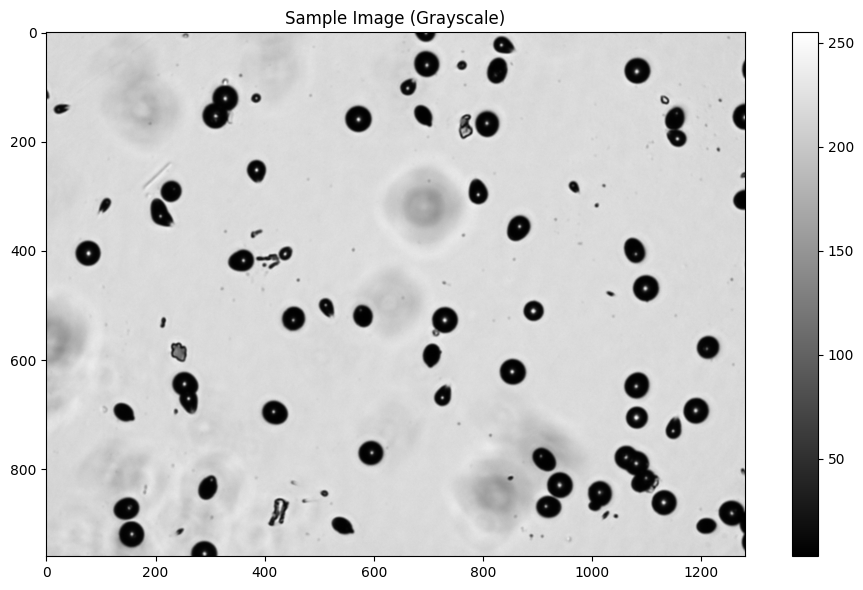

In [2]:
# Load all BMP images from the images folder
image_path = r"C:\Users\Sahar\Desktop\Tecnorad internship\images"
image_files = sorted(glob.glob(f"{image_path}/*.bmp"))

print(f"Found {len(image_files)} images")
print("Images:")
for img_file in image_files[:5]:  # Show first 5
    print(f"  - {img_file.split(chr(92))[-1]}")
if len(image_files) > 5:
    print(f"  ... and {len(image_files) - 5} more")

# Load and display sample image
sample_img_path = image_files[0]
sample_img = imread(sample_img_path, as_gray=True)
print(f"\nSample Image: {sample_img_path.split(chr(92))[-1]}")
print(f"Shape: {sample_img.shape}, Min: {sample_img.min():.2f}, Max: {sample_img.max():.2f}")

plt.figure(figsize=(10, 6))
plt.imshow(sample_img, cmap='gray')
plt.title('Sample Image (Grayscale)')
plt.colorbar()
plt.tight_layout()
plt.show()

## Approach 1: Laplacian of Gaussian (LoG)

In [3]:
def detect_blobs_log(image, max_sigma=30, num_sigma=10, threshold=0.1):
    """Detect blobs using Laplacian of Gaussian method"""
    blobs = blob_log(image, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)
    # Convert sigma to radius
    blobs[:, 2] = blobs[:, 2] * sqrt(2)
    return blobs

# Analyze LoG results for all images
log_results = {}

for img_path in image_files:
    img = imread(img_path, as_gray=True)
    blobs = detect_blobs_log(img)
    
    img_name = img_path.split(chr(92))[-1]
    log_results[img_name] = {
        'blobs': blobs,
        'count': len(blobs),
        'dimensions': blobs[:, 2] if len(blobs) > 0 else []
    }

# Display LoG results table
log_table_data = []
for img_name, result in log_results.items():
    blobs = result['blobs']
    count = len(blobs)
    if count > 0:
        avg_radius = np.mean(blobs[:, 2])
        min_radius = np.min(blobs[:, 2])
        max_radius = np.max(blobs[:, 2])
    else:
        avg_radius = min_radius = max_radius = 0
    
    log_table_data.append({
        'Image': img_name,
        'Count': count,
        'Avg Radius': f'{avg_radius:.2f}',
        'Min Radius': f'{min_radius:.2f}',
        'Max Radius': f'{max_radius:.2f}'
    })

log_df = pd.DataFrame(log_table_data)
print("LoG Detection Results:")
print(log_df.to_string(index=False))

LoG Detection Results:
 Image  Count Avg Radius Min Radius Max Radius
 1.bmp    500      10.69       1.41      42.43
10.bmp    966       7.79       1.41      42.43
11.bmp   1343       6.93       1.41      42.43
12.bmp    786       9.04       1.41      42.43
13.bmp    594       9.54       1.41      42.43
 2.bmp    588       9.55       1.41      42.43
 3.bmp    559       9.88       1.41      42.43
 4.bmp    603      10.25       1.41      42.43
 5.bmp    515      10.12       1.41      42.43
 6.bmp    633       9.94       1.41      42.43
 7.bmp    377      12.00       1.41      42.43
 8.bmp    567      10.29       1.41      42.43
 9.bmp    595       9.63       1.41      42.43


## Approach 2: Difference of Gaussians (DoG)

In [5]:
def detect_blobs_dog(image, max_sigma=30, threshold=0.1):
    """Detect blobs using Difference of Gaussians method"""
    blobs = blob_dog(image, max_sigma=max_sigma, threshold=threshold)
    # Convert sigma to radius
    if len(blobs) > 0:
        blobs[:, 2] = blobs[:, 2] * sqrt(2)
    return blobs

# Analyze DoG results for all images
dog_results = {}

for img_path in image_files:
    img = imread(img_path, as_gray=True)
    blobs = detect_blobs_dog(img)
    
    img_name = img_path.split(chr(92))[-1]
    dog_results[img_name] = {
        'blobs': blobs,
        'count': len(blobs),
        'dimensions': blobs[:, 2] if len(blobs) > 0 else []
    }

# Display DoG results table
dog_table_data = []
for img_name, result in dog_results.items():
    blobs = result['blobs']
    count = len(blobs)
    if count > 0:
        avg_radius = np.mean(blobs[:, 2])
        min_radius = np.min(blobs[:, 2])
        max_radius = np.max(blobs[:, 2])
    else:
        avg_radius = min_radius = max_radius = 0
    
    dog_table_data.append({
        'Image': img_name,
        'Count': count,
        'Avg Radius': f'{avg_radius:.2f}',
        'Min Radius': f'{min_radius:.2f}',
        'Max Radius': f'{max_radius:.2f}'
    })

dog_df = pd.DataFrame(dog_table_data)
print("DoG Detection Results:")
print(dog_df.to_string(index=False))

DoG Detection Results:
 Image  Count Avg Radius Min Radius Max Radius
 1.bmp    523       7.67       1.41      37.96
10.bmp   1123       5.89       1.41      37.96
11.bmp   1588       5.57       1.41      37.96
12.bmp    978       7.01       1.41      37.96
13.bmp    802       7.09       1.41      37.96
 2.bmp    724       7.00       1.41      37.96
 3.bmp    723       7.72       1.41      37.96
 4.bmp    727       7.49       1.41      37.96
 5.bmp    636       7.79       1.41      37.96
 6.bmp    754       7.24       1.41      37.96
 7.bmp    483       9.20       1.41      37.96
 8.bmp    736       7.62       1.41      37.96
 9.bmp    739       7.41       1.41      37.96


## Approach 3: Determinant of Hessian (DoH)

In [6]:
def detect_blobs_doh(image, max_sigma=30, num_sigma=10, threshold=0.01):
    """Detect blobs using Determinant of Hessian method"""
    blobs = blob_doh(image, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)
    # DoH returns radius directly, no need to scale
    return blobs

# Analyze DoH results for all images
doh_results = {}

for img_path in image_files:
    img = imread(img_path, as_gray=True)
    blobs = detect_blobs_doh(img)
    
    img_name = img_path.split(chr(92))[-1]
    doh_results[img_name] = {
        'blobs': blobs,
        'count': len(blobs),
        'dimensions': blobs[:, 2] if len(blobs) > 0 else []
    }

# Display DoH results table
doh_table_data = []
for img_name, result in doh_results.items():
    blobs = result['blobs']
    count = len(blobs)
    if count > 0:
        avg_radius = np.mean(blobs[:, 2])
        min_radius = np.min(blobs[:, 2])
        max_radius = np.max(blobs[:, 2])
    else:
        avg_radius = min_radius = max_radius = 0
    
    doh_table_data.append({
        'Image': img_name,
        'Count': count,
        'Avg Radius': f'{avg_radius:.2f}',
        'Min Radius': f'{min_radius:.2f}',
        'Max Radius': f'{max_radius:.2f}'
    })

doh_df = pd.DataFrame(doh_table_data)
print("DoH Detection Results:")
print(doh_df.to_string(index=False))

DoH Detection Results:
 Image  Count Avg Radius Min Radius Max Radius
 1.bmp    100      18.69       4.22      30.00
10.bmp    229      15.34       4.22      30.00
11.bmp    295      13.66       4.22      30.00
12.bmp    166      17.13       4.22      30.00
13.bmp     97      20.77       4.22      30.00
 2.bmp     90      18.97       4.22      30.00
 3.bmp    105      19.90       4.22      30.00
 4.bmp    120      19.47       4.22      30.00
 5.bmp     84      19.87       4.22      30.00
 6.bmp    110      17.99       4.22      30.00
 7.bmp     89      20.33       4.22      30.00
 8.bmp    102      19.32       4.22      30.00
 9.bmp    112      18.81       4.22      30.00


## Approach 4: Hough Circle Detection

In [7]:
def detect_circles_hough(image, min_radius=5, max_radius=50):
    """Detect circles using Hough Circle Transform"""
    # Enhance contrast
    p2, p98 = np.percentile(image, (2, 98))
    img_rescaled = exposure.rescale_intensity(image, in_range=(p2, p98))
    
    # Detect edges
    edges = canny(img_rescaled, sigma=2)
    
    # Apply Hough circle detection
    hough_radii = np.arange(min_radius, max_radius, 1)
    hough_res = hough_circle(edges, hough_radii)
    
    # Select the most prominent circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=500)
    
    # Return in format [y, x, radius]
    circles = np.column_stack([cy, cx, radii])
    return circles

# Analyze Hough Circle results for all images
hough_results = {}

for img_path in image_files:
    img = imread(img_path, as_gray=True)
    circles = detect_circles_hough(img)
    
    img_name = img_path.split(chr(92))[-1]
    hough_results[img_name] = {
        'blobs': circles,
        'count': len(circles),
        'dimensions': circles[:, 2] if len(circles) > 0 else []
    }

# Display Hough Circle results table
hough_table_data = []
for img_name, result in hough_results.items():
    circles = result['blobs']
    count = len(circles)
    if count > 0:
        avg_radius = np.mean(circles[:, 2])
        min_radius = np.min(circles[:, 2])
        max_radius = np.max(circles[:, 2])
    else:
        avg_radius = min_radius = max_radius = 0
    
    hough_table_data.append({
        'Image': img_name,
        'Count': count,
        'Avg Radius': f'{avg_radius:.2f}',
        'Min Radius': f'{min_radius:.2f}',
        'Max Radius': f'{max_radius:.2f}'
    })

hough_df = pd.DataFrame(hough_table_data)
print("Hough Circle Detection Results:")
print(hough_df.to_string(index=False))

Hough Circle Detection Results:
 Image  Count Avg Radius Min Radius Max Radius
 1.bmp    500      11.50       5.00      26.00
10.bmp    500       6.49       5.00      24.00
11.bmp    500       6.39       5.00      24.00
12.bmp    500       7.27       5.00      25.00
13.bmp    500      12.07       5.00      27.00
 2.bmp    500      10.65       5.00      24.00
 3.bmp    500      11.97       5.00      25.00
 4.bmp    500      14.19       5.00      25.00
 5.bmp    500      12.27       5.00      26.00
 6.bmp    500      10.06       5.00      24.00
 7.bmp    500      12.07       5.00      24.00
 8.bmp    500      11.91       5.00      24.00
 9.bmp    500      11.20       5.00      24.00


## Approach 5: Contour Detection

In [8]:
def detect_contours(image_path, min_area=50, max_area=50000):
    """Detect objects using contour analysis"""
    # Read image with OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return np.array([])
    
    # Apply threshold
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Extract circle data from contours
    circles = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            # Fit circle to contour
            (x, y), radius = cv2.minEnclosingCircle(contour)
            circles.append([y, x, radius])  # [y, x, radius] format
    
    return np.array(circles) if circles else np.array([]).reshape(0, 3)

# Analyze Contour Detection results for all images
contour_results = {}

for img_path in image_files:
    contours = detect_contours(img_path)
    
    img_name = img_path.split(chr(92))[-1]
    contour_results[img_name] = {
        'blobs': contours,
        'count': len(contours),
        'dimensions': contours[:, 2] if len(contours) > 0 else []
    }

# Display Contour Detection results table
contour_table_data = []
for img_name, result in contour_results.items():
    contours = result['blobs']
    count = len(contours)
    if count > 0:
        avg_radius = np.mean(contours[:, 2])
        min_radius = np.min(contours[:, 2])
        max_radius = np.max(contours[:, 2])
    else:
        avg_radius = min_radius = max_radius = 0
    
    contour_table_data.append({
        'Image': img_name,
        'Count': count,
        'Avg Radius': f'{avg_radius:.2f}',
        'Min Radius': f'{min_radius:.2f}',
        'Max Radius': f'{max_radius:.2f}'
    })

contour_df = pd.DataFrame(contour_table_data)
print("Contour Detection Results:")
print(contour_df.to_string(index=False))

Contour Detection Results:
 Image  Count Avg Radius Min Radius Max Radius
 1.bmp      0       0.00       0.00       0.00
10.bmp     29      30.12       5.17     158.11
11.bmp     34      33.39       4.74     180.84
12.bmp     21      26.56       4.47     115.41
13.bmp      0       0.00       0.00       0.00
 2.bmp      0       0.00       0.00       0.00
 3.bmp      0       0.00       0.00       0.00
 4.bmp      1       8.86       8.86       8.86
 5.bmp      1       4.95       4.95       4.95
 6.bmp      1      13.65      13.65      13.65
 7.bmp      0       0.00       0.00       0.00
 8.bmp      0       0.00       0.00       0.00
 9.bmp      0       0.00       0.00       0.00


## Comparison: All Approaches Summary

In [9]:
# Create comparison table for first 5 images
print("\n" + "="*100)
print("COMPREHENSIVE COMPARISON OF DETECTION METHODS")
print("="*100)

for i, img_name in enumerate(list(log_results.keys())[:5]):
    print(f"\n{img_name}")
    print("-" * 100)
    
    comparison_data = {
        'Method': ['LoG', 'DoG', 'DoH', 'Hough', 'Contour'],
        'Count': [
            log_results[img_name]['count'],
            dog_results[img_name]['count'],
            doh_results[img_name]['count'],
            hough_results[img_name]['count'],
            contour_results[img_name]['count']
        ]
    }
    
    # Add avg radius
    comparison_data['Avg Radius'] = []
    for method_results in [log_results, dog_results, doh_results, hough_results, contour_results]:
        blobs = method_results[img_name]['blobs']
        if len(blobs) > 0:
            comparison_data['Avg Radius'].append(f"{np.mean(blobs[:, 2]):.2f}")
        else:
            comparison_data['Avg Radius'].append("N/A")
    
    comp_df = pd.DataFrame(comparison_data)
    print(comp_df.to_string(index=False))


COMPREHENSIVE COMPARISON OF DETECTION METHODS

1.bmp
----------------------------------------------------------------------------------------------------
 Method  Count Avg Radius
    LoG    500      10.69
    DoG    523       7.67
    DoH    100      18.69
  Hough    500      11.50
Contour      0        N/A

10.bmp
----------------------------------------------------------------------------------------------------
 Method  Count Avg Radius
    LoG    966       7.79
    DoG   1123       5.89
    DoH    229      15.34
  Hough    500       6.49
Contour     29      30.12

11.bmp
----------------------------------------------------------------------------------------------------
 Method  Count Avg Radius
    LoG   1343       6.93
    DoG   1588       5.57
    DoH    295      13.66
  Hough    500       6.39
Contour     34      33.39

12.bmp
----------------------------------------------------------------------------------------------------
 Method  Count Avg Radius
    LoG    786       9.0

## Detailed Detection Analysis for Sample Image

In [10]:
# Analyze first image in detail
sample_name = list(log_results.keys())[0]
print(f"Detailed Analysis of: {sample_name}")
print("="*100)

# LoG Details
print("\nLoG - Laplacian of Gaussian")
print("-" * 100)
log_blobs = log_results[sample_name]['blobs']
if len(log_blobs) > 0:
    log_detail_data = []
    for idx, blob in enumerate(log_blobs[:20]):  # Show first 20
        log_detail_data.append({
            'ID': idx + 1,
            'Y Position': f'{blob[0]:.1f}',
            'X Position': f'{blob[1]:.1f}',
            'Radius': f'{blob[2]:.2f}',
            'Diameter': f'{blob[2]*2:.2f}'
        })
    log_detail_df = pd.DataFrame(log_detail_data)
    print(log_detail_df.to_string(index=False))
    print(f"... and {len(log_blobs) - 20} more" if len(log_blobs) > 20 else "")

# DoG Details
print("\n\nDoG - Difference of Gaussians")
print("-" * 100)
dog_blobs = dog_results[sample_name]['blobs']
if len(dog_blobs) > 0:
    dog_detail_data = []
    for idx, blob in enumerate(dog_blobs[:20]):  # Show first 20
        dog_detail_data.append({
            'ID': idx + 1,
            'Y Position': f'{blob[0]:.1f}',
            'X Position': f'{blob[1]:.1f}',
            'Radius': f'{blob[2]:.2f}',
            'Diameter': f'{blob[2]*2:.2f}'
        })
    dog_detail_df = pd.DataFrame(dog_detail_data)
    print(dog_detail_df.to_string(index=False))
    print(f"... and {len(dog_blobs) - 20} more" if len(dog_blobs) > 20 else "")

# DoH Details
print("\n\nDoH - Determinant of Hessian")
print("-" * 100)
doh_blobs = doh_results[sample_name]['blobs']
if len(doh_blobs) > 0:
    doh_detail_data = []
    for idx, blob in enumerate(doh_blobs[:20]):  # Show first 20
        doh_detail_data.append({
            'ID': idx + 1,
            'Y Position': f'{blob[0]:.1f}',
            'X Position': f'{blob[1]:.1f}',
            'Radius': f'{blob[2]:.2f}',
            'Diameter': f'{blob[2]*2:.2f}'
        })
    doh_detail_df = pd.DataFrame(doh_detail_data)
    print(doh_detail_df.to_string(index=False))
    print(f"... and {len(doh_blobs) - 20} more" if len(doh_blobs) > 20 else "")

Detailed Analysis of: 1.bmp

LoG - Laplacian of Gaussian
----------------------------------------------------------------------------------------------------
 ID Y Position X Position Radius Diameter
  1      706.0     1081.0   5.97    11.94
  2      511.0      892.0   5.97    11.94
  3      405.0       77.0   5.97    11.94
  4      527.0      730.0   5.97    11.94
  5      861.0     1131.0   5.97    11.94
  6       72.0     1081.0   5.97    11.94
  7      469.0     1097.0   5.97    11.94
  8      160.0      572.0   5.97    11.94
  9      693.0     1189.0   5.97    11.94
 10      622.0      853.0   5.97    11.94
 11      830.0      940.0   5.97    11.94
 12      166.0      779.0   5.97    11.94
 13      121.0      328.0   5.97    11.94
 14      252.0      385.0   5.97    11.94
 15      644.0      253.0   5.97    11.94
 16      867.0      429.0   5.97    11.94
 17       42.0      833.0   5.97    11.94
 18      957.0      290.0   5.97    11.94
 19      156.0     1279.0   5.97    11.94
 2

## Visual Comparison of Detection Methods

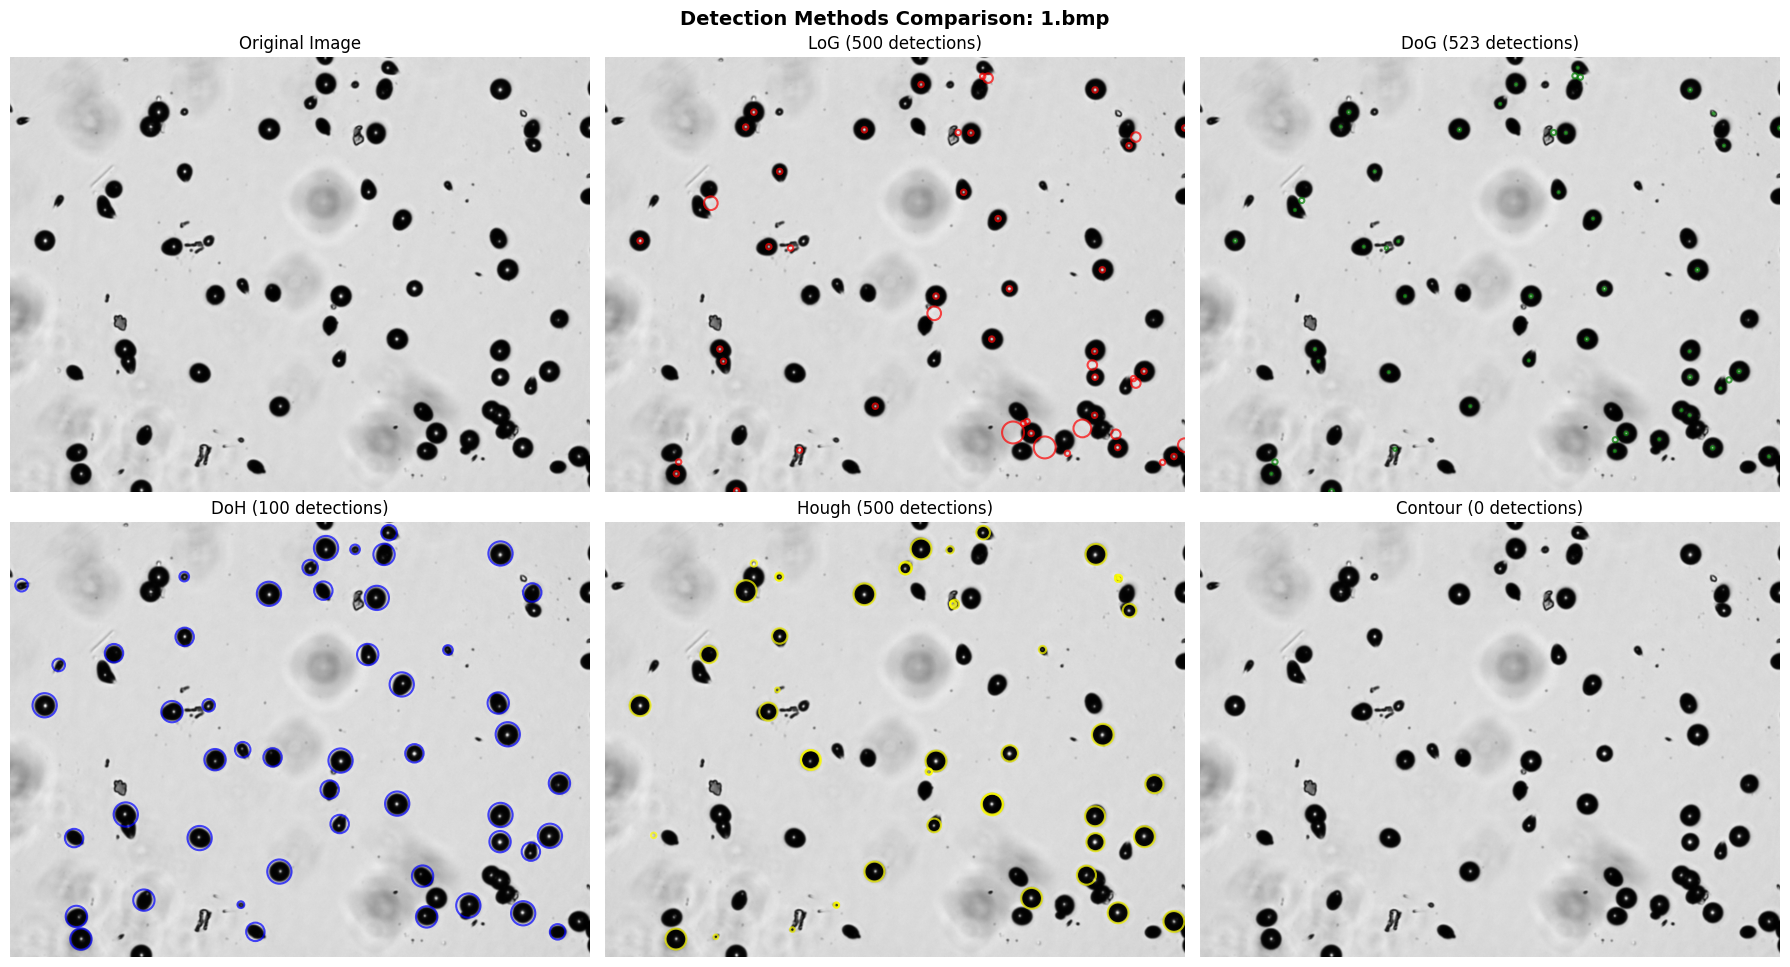

In [11]:
# Visualize detections for first image using LoG (as example)
sample_img_path = image_files[0]
sample_img = imread(sample_img_path, as_gray=True)
sample_name = sample_img_path.split(chr(92))[-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Detection Methods Comparison: {sample_name}', fontsize=14, fontweight='bold')

# Original image
ax = axes[0, 0]
ax.imshow(sample_img, cmap='gray')
ax.set_title('Original Image')
ax.axis('off')

# LoG
ax = axes[0, 1]
ax.imshow(sample_img, cmap='gray')
ax.set_title(f'LoG ({log_results[sample_name]["count"]} detections)')
for blob in log_results[sample_name]['blobs'][:50]:  # Limit to 50 for visibility
    y, x, r = blob
    c = Circle((x, y), r, color='red', linewidth=1.5, fill=False, alpha=0.7)
    ax.add_patch(c)
ax.axis('off')

# DoG
ax = axes[0, 2]
ax.imshow(sample_img, cmap='gray')
ax.set_title(f'DoG ({dog_results[sample_name]["count"]} detections)')
for blob in dog_results[sample_name]['blobs'][:50]:
    y, x, r = blob
    c = Circle((x, y), r, color='green', linewidth=1.5, fill=False, alpha=0.7)
    ax.add_patch(c)
ax.axis('off')

# DoH
ax = axes[1, 0]
ax.imshow(sample_img, cmap='gray')
ax.set_title(f'DoH ({doh_results[sample_name]["count"]} detections)')
for blob in doh_results[sample_name]['blobs'][:50]:
    y, x, r = blob
    c = Circle((x, y), r, color='blue', linewidth=1.5, fill=False, alpha=0.7)
    ax.add_patch(c)
ax.axis('off')

# Hough
ax = axes[1, 1]
ax.imshow(sample_img, cmap='gray')
ax.set_title(f'Hough ({hough_results[sample_name]["count"]} detections)')
for blob in hough_results[sample_name]['blobs'][:50]:
    y, x, r = blob
    c = Circle((x, y), r, color='yellow', linewidth=1.5, fill=False, alpha=0.7)
    ax.add_patch(c)
ax.axis('off')

# Contour
ax = axes[1, 2]
ax.imshow(sample_img, cmap='gray')
ax.set_title(f'Contour ({contour_results[sample_name]["count"]} detections)')
for blob in contour_results[sample_name]['blobs'][:50]:
    y, x, r = blob
    c = Circle((x, y), r, color='cyan', linewidth=1.5, fill=False, alpha=0.7)
    ax.add_patch(c)
ax.axis('off')

plt.tight_layout()
plt.show()

## Summary Statistics

In [12]:
print("\n" + "="*100)
print("OVERALL STATISTICS ACROSS ALL IMAGES")
print("="*100)

# Calculate statistics for each method
methods = {
    'LoG': log_results,
    'DoG': dog_results,
    'DoH': doh_results,
    'Hough': hough_results,
    'Contour': contour_results
}

stats_data = []
for method_name, results in methods.items():
    total_count = sum([r['count'] for r in results.values()])
    all_radii = []
    for r in results.values():
        if len(r['dimensions']) > 0:
            all_radii.extend(r['dimensions'])
    
    if all_radii:
        avg_radius = np.mean(all_radii)
        min_radius = np.min(all_radii)
        max_radius = np.max(all_radii)
        std_radius = np.std(all_radii)
    else:
        avg_radius = min_radius = max_radius = std_radius = 0
    
    stats_data.append({
        'Method': method_name,
        'Total Detections': total_count,
        'Avg Radius': f'{avg_radius:.2f}',
        'Min Radius': f'{min_radius:.2f}',
        'Max Radius': f'{max_radius:.2f}',
        'Std Dev': f'{std_radius:.2f}'
    })

stats_df = pd.DataFrame(stats_data)
print("\n" + stats_df.to_string(index=False))

print("\n" + "="*100)
print("RECOMMENDATIONS")
print("="*100)
print("""
1. LoG (Laplacian of Gaussian): Best for consistent detection of blob-like structures
   - Advantages: Fast, reliable, good for circular objects
   - Best for: Medium to large sized objects

2. DoG (Difference of Gaussians): Similar to LoG, slightly faster
   - Advantages: Computationally efficient
   - Best for: Real-time applications

3. DoH (Determinant of Hessian): Better for elongated or irregular shapes
   - Advantages: More sensitive to variations in shape
   - Best for: Objects with varying orientations

4. Hough Transform: Best for well-defined circular shapes
   - Advantages: Robust, finds incomplete circles
   - Best for: Clearly circular objects

5. Contour Detection: Best for distinct edges
   - Advantages: Works well with high contrast images
   - Best for: High contrast images with clear boundaries
""")


OVERALL STATISTICS ACROSS ALL IMAGES

 Method  Total Detections Avg Radius Min Radius Max Radius Std Dev
    LoG              8626       9.26       1.41      42.43    8.26
    DoG             10536       7.03       1.41      37.96    6.40
    DoH              1699      17.62       4.22      30.00    8.90
  Hough              6500      10.62       5.00      27.00    6.19
Contour                87      29.81       4.47     180.84   38.08

RECOMMENDATIONS

1. LoG (Laplacian of Gaussian): Best for consistent detection of blob-like structures
   - Advantages: Fast, reliable, good for circular objects
   - Best for: Medium to large sized objects

2. DoG (Difference of Gaussians): Similar to LoG, slightly faster
   - Advantages: Computationally efficient
   - Best for: Real-time applications

3. DoH (Determinant of Hessian): Better for elongated or irregular shapes
   - Advantages: More sensitive to variations in shape
   - Best for: Objects with varying orientations

4. Hough Transform: Bes